In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("assets/cardio_train.csv", sep = ";").drop(columns = "id")

print(df.shape)
df.head()

(70000, 12)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
df["age"] = df["age"] // 365

df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,47,1,156,56.0,100,60,1,1,0,0,0,0


# Disease Representation (2 A)

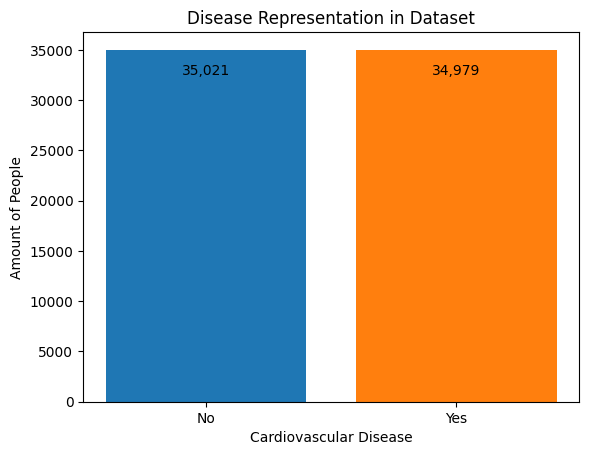

In [4]:
disease = {"No": 0, "Yes": 1}

fig, ax = plt.subplots() 

for i in disease.values(): # plot amount of each cardio value (0, 1) in df
    plt.bar(x = i, height = len(df[df["cardio"] == i]))

# set amount and position of ticks based on values, and map keys to them
plt.xticks(ticks = [value for value in disease.values()], labels = disease.keys())

for p in ax.containers: # show and format values on bars
    ax.bar_label(p, labels = [f"{val:,.0f}" for val in p.datavalues], padding = -20)

# set labels
ax.set(title = "Disease Representation in Dataset", xlabel = "Cardiovascular Disease", ylabel = "Amount of People");

# Cholesterol Levels (2 B)

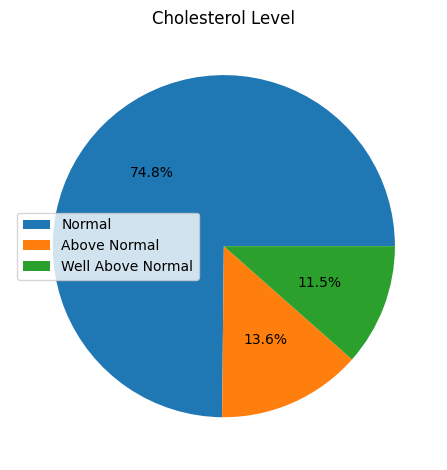

In [5]:
cholesterol = {"Normal": 1, "Above Normal": 2, "Well Above Normal": 3}

fig, ax = plt.subplots()

# plot amount of each cholesterol value (1, 2, 3) in df
plt.pie(x = [len(df[df["cholesterol"] == i]) for i in cholesterol.values()], autopct=lambda pct: f"{pct:.1f}%")

# map keys to legend
plt.legend(cholesterol.keys())

# set labels
ax.set(title = "Cholesterol Level")

plt.tight_layout()

# Age Distribution (2 C)

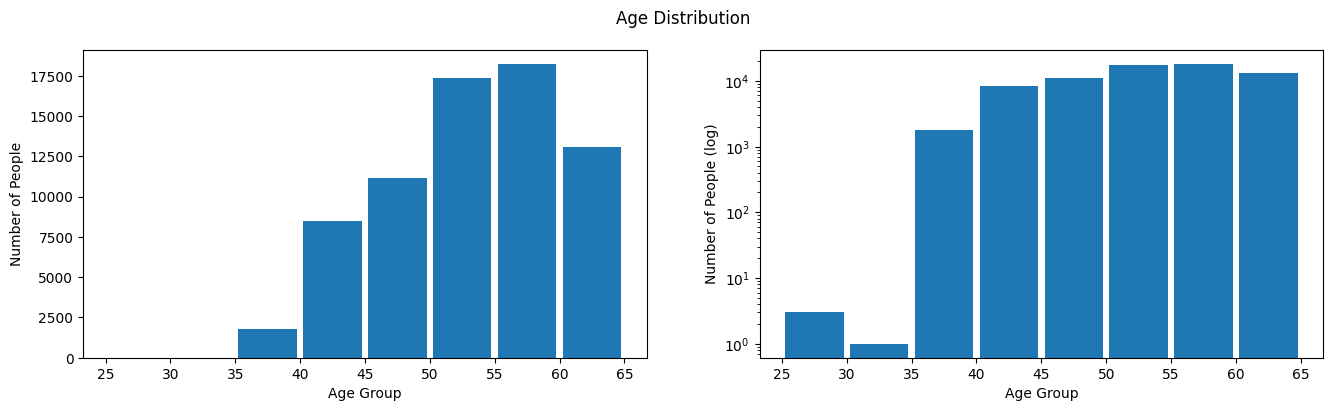

In [6]:
# pick out age groups between lowest and highest age in dataset
step = 5 # group size of bins (amount of years to group together)
start = (min(df["age"]) // step) * step # nearest multiple of [step] below min age
stop = (max(df["age"]) // step) * step + step # nearest multiple of [step] below max age, +[step] to get nearest multiple of [step] above max
bins = [i for i in range(start, stop+1, step)] # create bins list, +1 to be inclusive of last value

fig, axes = plt.subplots(1, 2, figsize = (16, 4))

# plot age grouped by bins, one normal and one log
for ax, log in zip(axes.flatten(), [False, True]):
    ax.hist(df["age"].values, bins, rwidth = 0.9, log = log) # rwidth <1 for space between bins
    ax.set(xlabel = "Age Group", ylabel = "Number of People" if log == False else "Number of People (log)") # set ylabel to reflect log state

fig.suptitle("Age Distribution");

# Smokers (2 D)

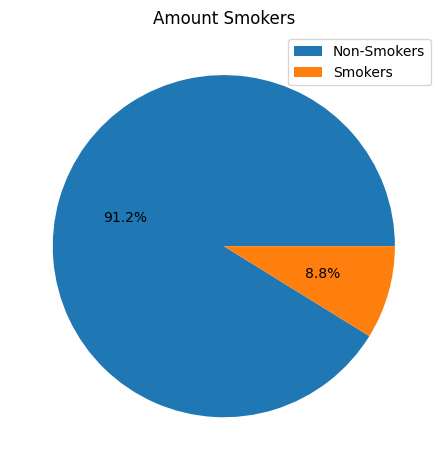

In [7]:
smoker = {"Non-Smokers": 0, "Smokers": 1}

fig, ax = plt.subplots()


# plot amount of each smoker value (0, 1) in df
plt.pie(x = [len(df[df["smoke"] == i]) for i in smoker.values()], autopct=lambda pct: f"{pct:.1f}%")

# map keys to legend
plt.legend(smoker.keys())

# set labels
ax.set(title = "Amount Smokers")

plt.tight_layout()

# Weight Distribution (2 E)

### Distplot with KDE

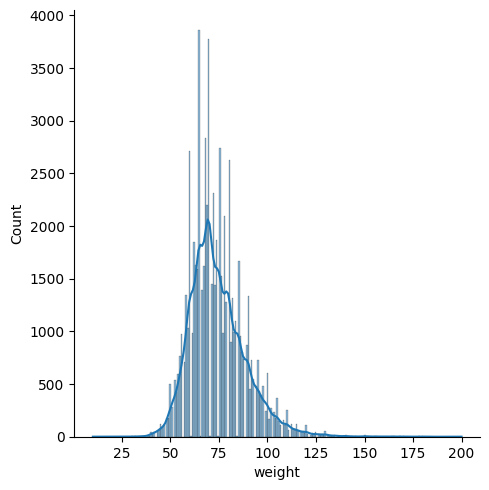

In [8]:
sns.displot(df["weight"], kde = True);

### Violinplot showing outliers

In [9]:
Q1 = df["weight"].quantile(0.25)
Q3 = df["weight"].quantile(0.75)
IQR = Q3 - Q1

# seaborn boxplot definition of outliers
outlier_lower = Q1 - 1.5 * IQR
outlier_upper = Q3 + 1.5 * IQR

outlier_lower, outlier_upper

(39.5, 107.5)

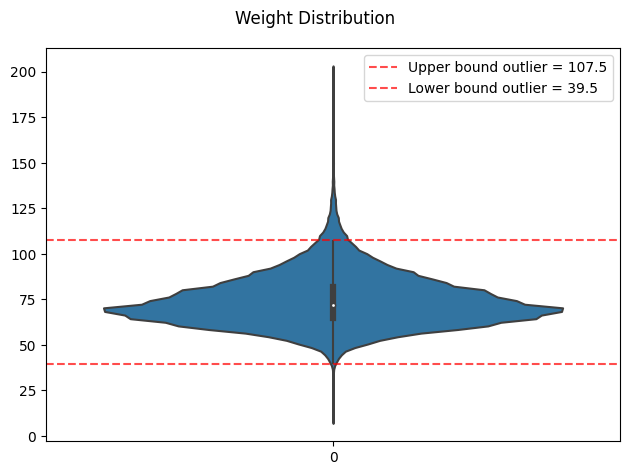

In [10]:
sns.violinplot(df["weight"])
plt.axhline(y = outlier_upper, label = f"Upper bound outlier = {outlier_upper}", color = "r", linestyle = "--", alpha = 0.7)
plt.axhline(y = outlier_lower, label = f"Lower bound outlier = {outlier_lower}", color = "r", linestyle = "--", alpha = 0.7)
plt.legend()
plt.suptitle("Weight Distribution")
plt.tight_layout()